# 1.Install the Surface Coil Intensity Correction package:

In [1]:
!pip3 install /home/Xuan/LGE_project/git_rewriten/Python_read_Siemens_rawdata/brightness_correction/dist/brightness_correction-0.4.tar.gz

Processing ./Python_read_Siemens_rawdata/brightness_correction/dist/brightness_correction-0.4.tar.gz
  Created wheel for brightness-correction: filename=brightness_correction-0.4-py3-none-any.whl size=17259 sha256=ff40bc837ba6eb2621cc76870790a1aba70e7faed132a3a214cbdeddf4fb541c
  Stored in directory: /home/Xuan/.cache/pip/wheels/c8/91/32/5e25365b3f33e622c397eec4ad570f1986f652e8df0da15418
Successfully built brightness-correction
  Attempting uninstall: brightness-correction
    Found existing installation: brightness-correction 0.4
    Uninstalling brightness-correction-0.4:
      Successfully uninstalled brightness-correction-0.4


# 2.Install twixtools modified by Chong

https://github.com/OSU-MR/Python_read_Siemens_rawdata

# 3. organize the folders of your datasets
# **The sturcture of your dataset folders should be like this:**


```markdown
base_dir-----input_folder-----folder name of your datasets_1
          |                |--folder name of your datasets_2
          |                |              ...
          |		   --folder name of your datasets_n
          |
          |
          |
          ---output_folder------correction map folder of your datasets_1   (these folders in the output folder 
			     |--correction map folder of your datasets_2         will be automatically created)
			     |                ...                 
                             ---correction map folder of your datasets_n
```

# 4. importing the functions and define the folders

In [2]:
from brightness_correction.brightness_correction import getting_and_saving_correction_map, create_and_start_threadings, displaying_results
base_dir = "../"
input_folder = "rawdata"
output_folder = "correction_maps_demo"
input_folder_names = ['dataset_1'] #set this to None, if you want to go through all the folders in the input_folder

please read README.md to run the code.
The code is still under development.
support data shape: 
['Set',Sli,'Avg',...]
['Set','Avg',...]
these data shape may work:
[Sli,'Avg',...]
['Avg',...]
plesae contact me for adding more data shape support.
lei.337@osu.edu


# 5. define custom function for user defined processing

In [3]:
import numpy as np
def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

def CustomProcedure(img_body_coils, img_surface_coils, ksp, ref_padded, noise_kspace, dim_info_noise):

    # print('img_body_coils.shape', img_body_coils.shape)
    # print('img_surface_coils.shape', img_surface_coils.shape)
    # print('ksp.shape', ksp.shape)
    # print('ref_padded.shape', ref_padded.shape)
    # print('noise_kspace.shape', noise_kspace.shape)
    # print('dim_info_noise.shape', dim_info_noise.shape)

    img_body_coils = rms_comb(img_body_coils,0)
    img_surface_coils = rms_comb(img_surface_coils,0)

    #set Stop to True to stop the program for debugging
    Stop = False
    assert not Stop, "Stopped for debugging"
    
    return img_body_coils, img_surface_coils , ksp, ref_padded

# 6. start the correcting

In [4]:
num_thread = 1 # define the number of threads
threads = create_and_start_threadings(num_thread, getting_and_saving_correction_map, base_dir, 
                                      input_folder, output_folder, input_folder_names, 
                                      auto_rotation='LGE',debug = True,
                                      apply_correction_during_sense_recon=False,CustomProcedure=CustomProcedure)

Thread 0 has been created! please wait until it finishes!
Software version: VD/VE (!?)



Scan  0


100%|██████████| 56.2M/56.2M [00:00<00:00, 426MB/s]


Scan  1


100%|██████████| 535M/535M [00:00<00:00, 1.78GB/s]



number of separate scans (multi-raid): 2
pad size: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
['Set', 'Ave', 'Lin', 'Cha', 'Col']
pad size: [(0, 0), (0, 0), (0, 0)]
['Lin', 'Cha', 'Col']
['Set', 'Ave', 'Lin', 'Cha', 'Col']
multiple sets
original data shape: (2, 32, 32, 30, 128)
['Set', 'Par', 'Lin', 'Cha', 'Col']
(2, 32, 32, 30, 128)
1 1
arranged data shape (128, 32, 32, 30, 2, 1, 1)
['RO', 'E1', 'E2', 'Cha', 'Set', 'S', 'Sli']
3d image shape: (128, 32, 32, 30, 2)
*******************dim_info_org**********************
('Set', 2) ('Ave', 30) ('Lin', 150) ('Cha', 30) ('Col', 512) 

Dimension 'Phs' not found, skipping.
Dimension 'Set' not found, skipping.
Dimension 'Sli' not found, skipping.
scan_index 0
scan_index 1
custom procedure found and used!
apply_correction_during_sense_recon:  False


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

Thread 0 is done! You can find the results in the output folder! You can also display the results by using the function displaying_results(). Please check cells below!


# You can check if the thread is alive like this:

In [33]:
for i in range(len(threads)):
   print(threads[i].is_alive())


False


# 7.for displaying the result, you can use displaying_results function like this:

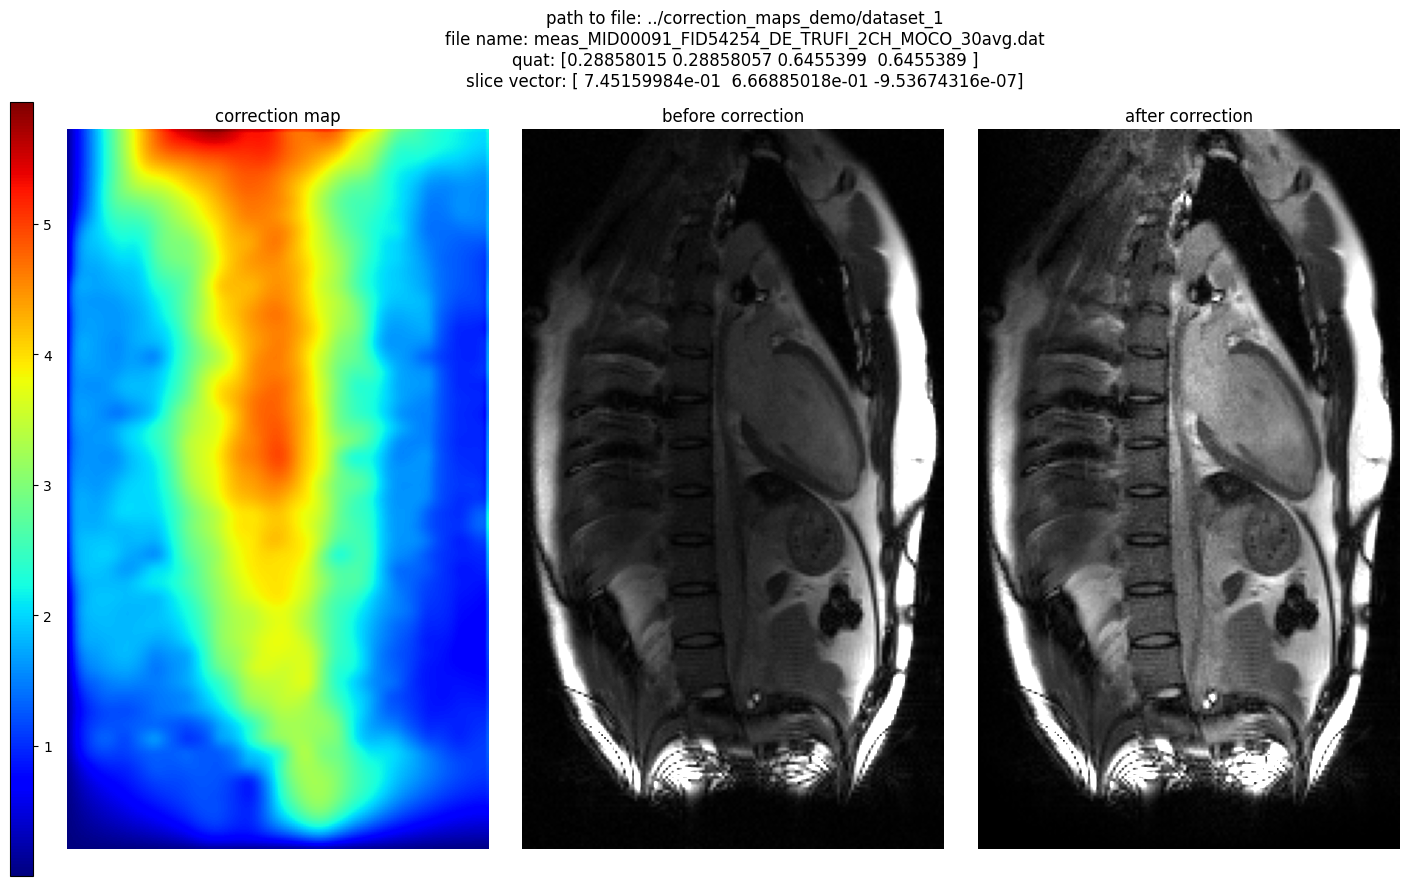

In [10]:
output_folder_names = ['dataset_1']
output_folder = "correction_maps_demo"
displaying_results(base_dir=base_dir, input_folder=input_folder,
                   output_folder=output_folder, folder_names=output_folder_names, sli_idx=0,
                   fig_h=9, debug=False) #set debug = True to display more information
